In [52]:
import os
import sys

from get_results import getMeasurementsResults

import json
import requests
from shapely.geometry import Point
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
import datetime

from ripe.atlas.sagan import (
  TracerouteResult,
  PingResult,
)

from funcy import group_by

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
starlink_global_accelerator = getMeasurementsResults([47171922], TracerouteResult)[0]
starlink_regions = getMeasurementsResults([47597068, 47597069, 47597070, 47597071, 47597072, 47597073, 47597074, 47597075, 47597078, 47597079, 47597080, 47597081, 47597082, 47597083, 47597084, 47597085, 47597086, 47597088, 47597089, 47597090, 47597092, 47597093, 47597094, 47597095, 47597096, 47597097, 47597099, 47597100, 47597102, 47597103, 47597105, 47597106, 47597107, 47597108, 47597109, 47597110, 47597111, 47597112, 47597113, 47597114, 47597115, 47597116, 47597117, 47597118, 47597119, 47597121, 47597122, 47597124, 47597125, 47597126, 47597129, 47597130, 47597131, 47597132, 47597133, 47597134, 47597135, 47597136, 47597137, 47597138, 47597139, 47597140, 47597141, 47597142, 47597143, 47597144, 47597146, 47597147, 47597148, 47597149, 47597150, 47597151, 47597152, 47597153, 47597154, 47597155, 47597156, 47597157], TracerouteResult)

In [61]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def isUsingCarrierGradeNAT(traceroute):
  for hop in traceroute.hops:
    if hop.packets[0].origin == '100.64.0.1':
      return True
  return False

def carrier_nat_rtts(traceroute):
    packets = flatten([h.packets for h in traceroute.hops])
    carrier_nat_packets = [p for p in packets if p.origin == '100.64.0.1']
    return [p.rtt for p in carrier_nat_packets if p.rtt]

def tracerouteMinRtt(measurement):
  rtts = [x.rtt for x in measurement.hops[-1].packets if x.rtt and x.origin == measurement.destination_address]
  if len(rtts) == 0:
    return None
  return min(rtts)

def style_graph_cdf(ax, xlabel='Minimum RTT (ms)'):
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel('% of Probes', size=24)
    ax.set_xlabel(xlabel, size=24)
    ax.tick_params(axis='both', which='major', labelsize=18)

def plotCDF(data, ax=plt, **kwargs):
  ax.plot(sorted(data), np.arange(len(data)) / len(data), **kwargs)

In [62]:
results = {}
total_traceroutes = 0
for x in starlink_regions:
    region = x[0].description
    for traceroute in x[1]:
        if isUsingCarrierGradeNAT(traceroute):
            if not traceroute.probe_id in results:
                results[traceroute.probe_id] = {}
            if not region in results[traceroute.probe_id]:
                results[traceroute.probe_id][region] = {}
                results[traceroute.probe_id][region]['rtt'] = []
                results[traceroute.probe_id][region]['nat_rtt'] = []
            if tracerouteMinRtt(traceroute) != None:
                total_traceroutes += 1
                results[traceroute.probe_id][region]['rtt'].append(tracerouteMinRtt(traceroute))
                results[traceroute.probe_id][region]['nat_rtt'].append(min(carrier_nat_rtts(traceroute)))

probe_id_to_region_min = {}
probe_id_to_nat_rtt = {}
for probe_id, vs in results.items():
    rtt_by_region = {}
    nat_rtt_by_region = {}
    for region, data in vs.items():
        rtts = data['rtt']
        nat_rtts = data['nat_rtt']
        if len(rtts) > 0:
            rtt_by_region[region] = rtts
            nat_rtt_by_region[region] = nat_rtts
    fastest_region = sorted(rtt_by_region.items(), key=lambda x: min(x[1]))[0][0]
    probe_id_to_nat_rtt[probe_id] = nat_rtt_by_region[fastest_region]
    probe_id_to_region_min[probe_id] = min(rtt_by_region[fastest_region])

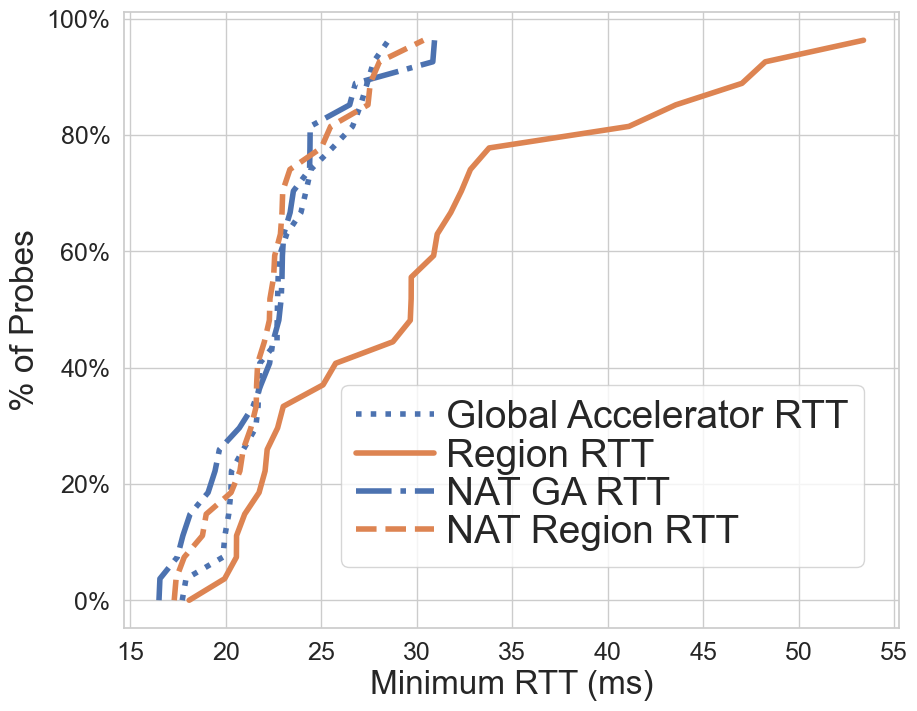

In [63]:
sns.set_theme()
sns.set_style("whitegrid")

cmap = sns.color_palette()

all_results = [[x.probe_id, min(carrier_nat_rtts(x)), tracerouteMinRtt(x)] for x in starlink_global_accelerator[1] if tracerouteMinRtt(x) and isUsingCarrierGradeNAT(x)]
results_by_probe_id = group_by(lambda x: x[0], all_results)
probe_id_to_ga_times = {k:[x[2] for x in v] for k, v in results_by_probe_id.items()}
probe_id_to_nat_times = {k:[x[1] for x in v] for k, v in results_by_probe_id.items()}
probe_id_to_min_ga_times = {k:min(v) for k,v in probe_id_to_ga_times.items()}

fig, ax = plt.subplots(figsize=(10, 8))
plotCDF(probe_id_to_min_ga_times.values(), ax, label='Global Accelerator RTT', linewidth=4, color=cmap[0], linestyle='dotted')
plotCDF(probe_id_to_region_min.values(), ax, label = 'Region RTT', linewidth=4, color=cmap[1], linestyle='solid')
plotCDF([min(x) for x in probe_id_to_nat_times.values()], ax, label = 'NAT GA RTT', linewidth=4, color=cmap[0], linestyle='dashdot')
plotCDF([min(x) for x in probe_id_to_nat_rtt.values()], ax, label = 'NAT Region RTT', linewidth=4, color=cmap[1],  linestyle='dashed')
style_graph_cdf(ax)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc=(0.28, 0.1),
)
fig.savefig('images/starlink_cdfs.png', bbox_inches='tight', dpi=300)
plt.show()

In [53]:
continents = ['na', 'sa', 'eu', 'af', 'as', 'oc']

def continentToLabel(region):
    if region == "na":
        return "North America"
    if region == "sa":
        return "South America"
    if region == "oc":
        return "Oceania"
    if region == "as":
        return "Asia"
    if region == "af":
        return "Africa"
    if region == "eu":
        return "Europe"
    return region

@dataclass
class Datacenter:
    name: str
    location: Point
    local: bool
    edge: bool
    launched: str

    def dateTime(self):
        if self.launched:
            return datetime.datetime.strptime(self.launched, "%m-%d-%Y").date()
        return None
        
    def region(self):
        return not (self.local or self.edge)

def loadDatacenters():
    with open('./data/available_cities.json') as f:
        available_cities = json.load(f)
        return [Datacenter(a['name'], Point(a['longitude'], a['latitude']), a['local'], a['edge'], a.get('launched')) for a in available_cities]

datacenters = loadDatacenters()
region_names = [d.name['name'] if type(d.name) is dict else d.name for d in datacenters if d.region()]
region_names = [n.split(',')[0].replace(' ', '-') for n in region_names]
def name_is_region(name):
    return name in region_names

In [40]:
import geopandas as gpd
import pandas as pd
import rasterio
from geopandas.tools import sjoin
from rasterstats import zonal_stats

def gdf_pop(pop_raster, selected_admin_data):
    affine = pop_raster.transform
    ndval = pop_raster.nodatavals[0]
    array = pop_raster.read(1)
    df_zonal_stats = pd.DataFrame(
        zonal_stats(
            selected_admin_data,
            array,
            nodata=ndval,
            affine=affine,
            stats=['sum']))
    selected_admin_data['population'] = list(df_zonal_stats['sum'])
    return selected_admin_data

admin_data = gpd.read_file("./data/gadm_410-levels.gpkg", layer='ADM_2')
pop_raster = rasterio.open('./data/gpw_v4_population_count_rev11_2020_15_min.tif')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
pop_gdf_per_continent = {}
gdf = gdf_pop(pop_raster, admin_data)
gdf_continent = sjoin(gdf, world, how='left')
gdf_continent = gdf_continent.drop_duplicates(subset=['GID_2'])
gdf_continent = gdf_continent[gdf_continent['population'].notna()]
for region in continents:
    gdf_selected = gdf_continent[gdf_continent['continent'] == continentToLabel(region)]
    pop_gdf_per_continent[region] = gdf_selected

/var/folders/r3/739xvycd5qq1b2r8q0tghs4c0000gn/T/ipykernel_73953/3320986897.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [54]:
import numpy as np
import matplotlib.pyplot as plt

def resultsForContinent(continent):
    src_to_region_id = {}
    base_stations_file = f"./data/starlink_simulator/ground_stations_aws_{continent}.basic.txt"
    region_ids = []
    with open(base_stations_file, 'r') as f:
        lines = f.readlines()
        for l in lines[0:110]:
            location = l.split(',')[1]
            if name_is_region(location):
                region_ids.append(int(l.split(',')[0]))
        for l in lines[110:]:
            src = l.split(',')[0]
            region = l.split(',')[1]
            src_to_region_id[int(src)] = region

    duration = 120 if continent != 'eu' else 5
    result_path = f"./data/starlink_simulator/starlink_550_isls_plus_grid_ground_stations_aws_{continent}_algorithm_free_one_only_over_isls/5000ms_for_{duration}s/manual/data/"
    gdf_pop = pop_gdf_per_continent[continent]
    rtt_files = [f for f in os.listdir(result_path) if '_rtt_' in f]
    src_to_dst_map = {}
    for file in rtt_files:
        splits = os.path.splitext(file)[0].split('_')
        src = int(splits[2]) - 1584
        dest = int(splits[4]) - 1584
        if not src in src_to_dst_map:
            src_to_dst_map[src] = {}
        min_rtt = 1000000000
        with open(result_path + file, 'r') as f:
            for line in f.readlines():
                rtt = float(line.split(',')[1]) / 1000000
                if rtt < min_rtt:
                    min_rtt = rtt
        if not dest in src_to_dst_map[src]:
            src_to_dst_map[src][dest] = min_rtt
        elif min_rtt < src_to_dst_map[src][dest]:
            src_to_dst_map[src][dest] = min_rtt

    src_to_min_rtt = {}
    src_to_min_region_rtt = {}
    for src, rtt_map in src_to_dst_map.items():
        min_rtt = 100000000
        min_region_rtt = 1000000000
        for dst, rtt in rtt_map.items():
            if rtt < min_rtt:
                min_rtt = rtt
            if dst in region_ids and rtt < min_region_rtt:
                min_region_rtt = rtt
        src_to_min_region_rtt[src] = min_region_rtt
        src_to_min_rtt[src] = min_rtt

    results = []
    for src, min_rtt in src_to_min_rtt.items():
        region_id = src_to_region_id[src]
        df_selected_population = list(gdf_pop[gdf_pop['GID_2']==region_id]['population'])
        if len(df_selected_population) > 0:
            population = df_selected_population[0]
            results.append((min_rtt, population))
            
    region_results = []
    for src, min_rtt in src_to_min_region_rtt.items():
        region_id = src_to_region_id[src]
        df_selected_population = list(gdf_pop[gdf_pop['GID_2']==region_id]['population'])
        if len(df_selected_population) > 0:
            population = df_selected_population[0]
            region_results.append((min_rtt, population))

    results = sorted(results)
    region_results = sorted(region_results)
    populations = [x[1] for x in results]
    min_rtts = [x[0] for x in results]
    region_populations = [x[1] for x in region_results]
    region_min_rtts = [x[0] for x in region_results]
    return populations, min_rtts, region_populations, region_min_rtts

In [56]:
def percentile(p, x, cum_percent):
    for i in range(0, len(cum_percent)):
        if cum_percent[i] >= p:
            return x[i]

edge_10 = []
edge_20 = []
region_10 = []
region_20 = []
for continent in continents:
    populations, min_rtts, region_populations, region_min_rtts = resultsForContinent(continent)
    total_pop = sum(populations)
    region_total_pop = sum(region_populations)
    if total_pop != region_total_pop:
        print("Not right")
    percentages = np.cumsum(populations) / total_pop
    region_percentages = np.cumsum(populations) / total_pop
    
    print([a for a in min_rtts if a > 0][0])

    p90 = percentile(0.9, min_rtts, percentages)
    p10 = percentile(0.1, min_rtts, percentages)
    
    p90_region = percentile(0.9, region_min_rtts, region_percentages)
    p10_region = percentile(0.1, region_min_rtts, region_percentages)

    edge_10.append(p90/p10)
    edge_20.append(percentile(0.8, min_rtts, percentages) / percentile(0.2, min_rtts, percentages))
    region_10.append(p90_region/p10_region)
    region_20.append(percentile(0.8, region_min_rtts, region_percentages) / percentile(0.2, region_min_rtts, region_percentages))
    print(continent)
    print(f"region: {round(p10_region, 2)} {round(p90_region, 2)}")
    print(f"edge: {round(p10, 2)} {round(p90, 2)}")

6.876306449643907
na
region: 7.84 25.55
edge: 7.73 23.49
7.568565984405118
sa
region: 8.61 72.12
edge: 8.34 36.57
6.874599018431612
eu
region: 7.34 24.9
edge: 7.17 24.1
6.957132157073811
af
region: 10.65 55.31
edge: 9.51 47.28
7.026376102163318
as
region: 9.55 60.99
edge: 9.41 60.5
6.974440381018524
oc
region: 7.64 44.86
edge: 7.03 25.09


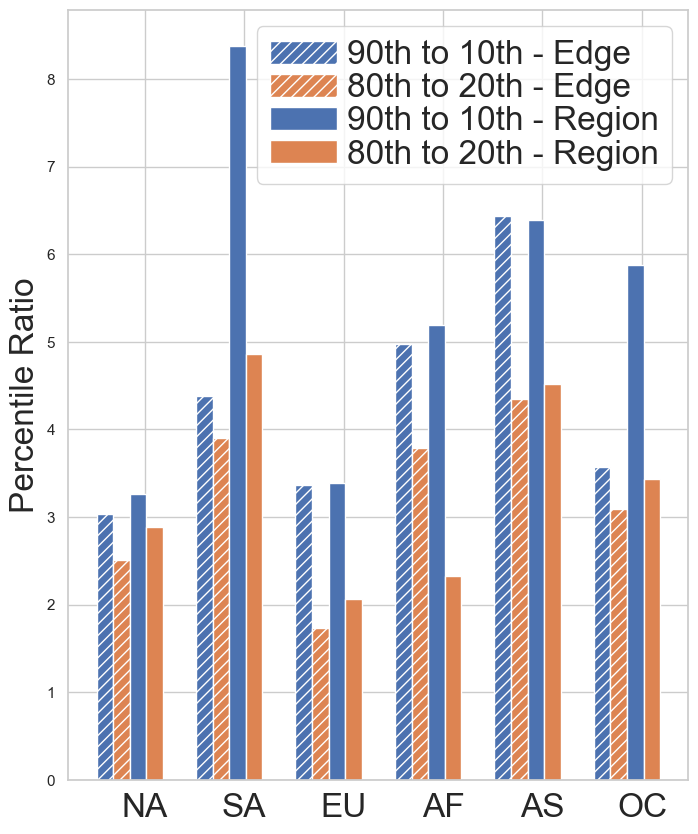

In [59]:
fig, ax = plt.subplots(figsize=(8, 10))
x = np.arange(len(continents))
width = 1
count=6
colors = sns.color_palette()
rects1 = ax.bar(x - 3*width/count, edge_10, width/count, label='90th to 10th - Edge', hatch='///', color=colors[0])
rects1 = ax.bar(x - 2*width/count, edge_20, width/count, label='80th to 20th - Edge', hatch='///', color=colors[1])
rects2 = ax.bar(x - width/count, region_10, width/count, label='90th to 10th - Region', color=colors[0])
rects2 = ax.bar(x, region_20, width/count, label='80th to 20th - Region', color=colors[1])

ax.set_xticks([p-0.1 for p in x], [c.upper() for c in continents], fontsize="24")
ax.set_ylabel('Percentile Ratio', size='24')
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="24",
)
fig.savefig('images/distance_gap_leo.png', bbox_inches='tight', dpi=300)